<a href="https://colab.research.google.com/github/aaryyya/MLDL_Assignments/blob/main/rf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna shap econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import optuna
from xgboost import XGBClassifier

# === Load datasets ===
df_num = pd.read_csv("preprocessed_dataset.csv")
df_train_img = pd.read_csv("extracted_features_train.csv")
df_test_img = pd.read_csv("extracted_features_test.csv")

# === Prepare data ===
label_col = 'trojan_type'
features_to_scale = [col for col in df_num.columns if col != label_col]
total_needed = len(df_train_img) + len(df_test_img)

# === Split structured data ===
num_train = df_num.iloc[:len(df_train_img)].reset_index(drop=True)
num_test = df_num.iloc[len(df_train_img):total_needed].reset_index(drop=True)

# === Normalize ===
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(num_train[features_to_scale]), columns=features_to_scale)
scaled_test = pd.DataFrame(scaler.transform(num_test[features_to_scale]), columns=features_to_scale)

# === Clean image features ===
df_train_img = df_train_img.select_dtypes(include='number').reset_index(drop=True)
df_test_img = df_test_img.select_dtypes(include='number').reset_index(drop=True)

# === Combine features ===
X_train = pd.concat([df_train_img, scaled_train], axis=1)
X_test = pd.concat([df_test_img, scaled_test], axis=1)

# === Encode labels ===
le = LabelEncoder()
y_train = le.fit_transform(num_train[label_col])
y_test = le.transform(num_test[label_col])

# === Hyperparameter tuning function ===
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

print("🔍 Running Optuna tuning (XGBoost)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)  # can increase to 30 if needed

# === Best model ===
print("\n✅ Best Parameters:", study.best_params)
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# === Evaluation ===
print("\n📊 Final Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))
print(f"✅ Final Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")



[I 2025-04-16 03:23:14,543] A new study created in memory with name: no-name-49fc535e-8992-4b8e-94e5-ba1c8027b3f4


🔍 Running Optuna tuning (XGBoost)...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:23:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:23:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:23:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-16 03:23:17,988] Trial 0 finished with value: 0.8863120167758133 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.07977384562727177, 'subsample': 0.9549393199978587, 'colsample_bytree': 0.9414317769047849, 'gamma': 3.9351455478813295, 'reg_alpha': 1.8217687619882914, 'reg_lambda': 1.28426


✅ Best Parameters: {'n_estimators': 232, 'max_depth': 6, 'learning_rate': 0.12536840460810958, 'subsample': 0.7893634826558337, 'colsample_bytree': 0.8835234034031741, 'gamma': 3.677693766949272, 'reg_alpha': 0.0010363824217649587, 'reg_lambda': 1.3397698711807853}

📊 Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.68      0.61      0.64        41
           2       0.94      0.86      0.90        35
           3       0.67      0.33      0.44         6
           4       0.97      0.87      0.92        38
           5       0.75      0.56      0.64        32
           6       0.97      0.95      0.96        38
           7       0.94      0.97      0.95        32
           8       0.67      0.50      0.57        24
           9       0.60      0.41      0.48        37
          10       0.89      0.40      0.55        20
          11       0.92      1.00      0.96       62

In [ ]:
!pip install shap

In [ ]:
import sklearn
print(sklearn.__version__)


1.2.2



📈 Running SHAP (model-agnostic) with KernelExplainer...


  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'plt' is not defined

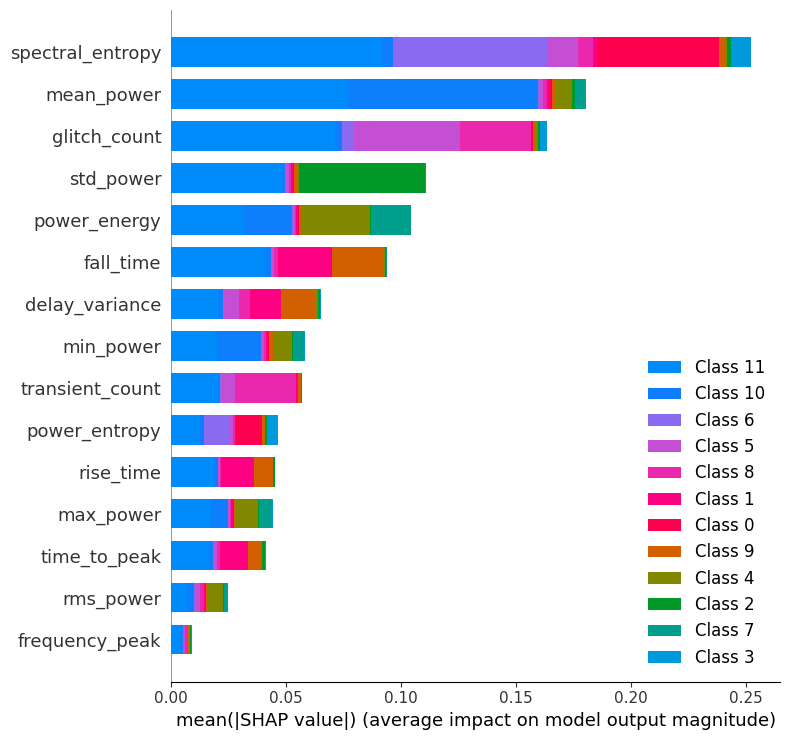

In [ ]:
import shap

# === KernelExplainer for XGBoost ===
print("\n📈 Running SHAP (model-agnostic) with KernelExplainer...")

# Use a small sample (due to computational cost)
X_background = shap.sample(X_train, 100, random_state=0)
X_explain = shap.sample(X_test, 50, random_state=1)

def model_predict(X):
    return best_model.predict_proba(X)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_explain)




✅ SHAP (Kernel) summary saved as 'shap_kernel_summary_xgb.png'


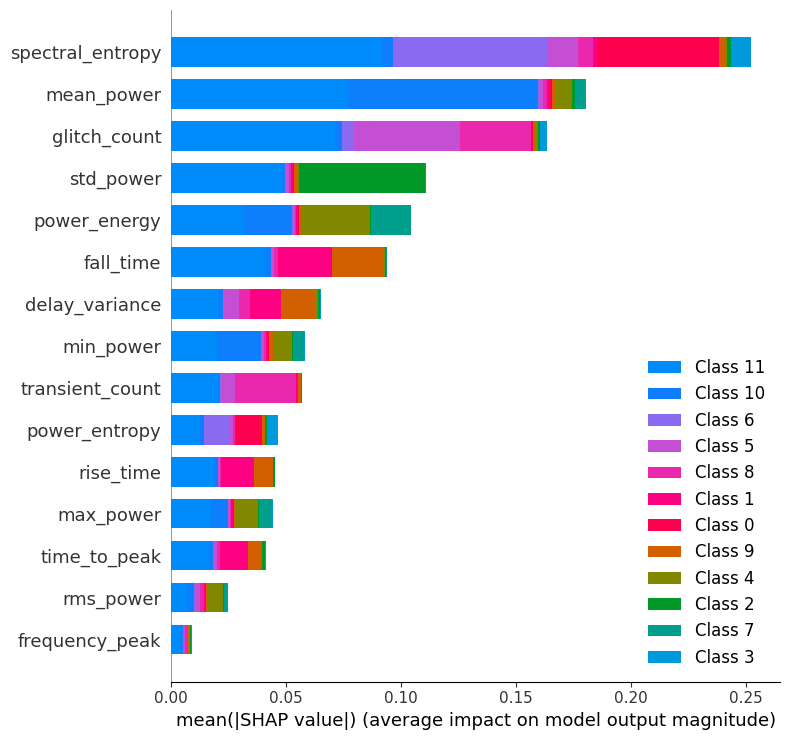

In [ ]:
# Plot summary
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_explain, show=False)
plt.savefig("shap_kernel_summary_xgb.png", bbox_inches='tight')
print("✅ SHAP (Kernel) summary saved as 'shap_kernel_summary_xgb.png'")

In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

print("\n🌲 Estimating causal effect of model decisions using CausalForestDML...")

# === Prepare data ===
le = LabelEncoder()
y_true_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

# Outcome: 1 if prediction correct, else 0
outcome = (y_true_encoded == y_pred_encoded).astype(int)

# Use subset (for speed)
sample_n = 300
X_causal = X_test[:sample_n]
T = y_pred_encoded[:sample_n]   # Treatment: predicted class
Y = outcome[:sample_n]          # Outcome: correct prediction (1/0)

# CausalForestDML requires treatment to be binary — so we model pairwise effect
# To do multiclass, estimate effects for one-vs-rest (or pairwise manually)

# Example: Estimate effect of predicting class A (vs not predicting it)
target_class = 0  # Change this to test for other classes
T_binary = (T == target_class).astype(int)

cf_model = CausalForestDML(
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)

cf_model.fit(Y, T_binary, X=X_causal)

# Estimate treatment effect (ATE) for predicting this class
te_pred = cf_model.effect(X_causal)
avg_te = np.mean(te_pred)

print(f"\n🧪 Average Treatment Effect of predicting class {le.inverse_transform([target_class])[0]}: {avg_te:.4f}")



🌲 Estimating causal effect of model decisions using CausalForestDML...

🧪 Average Treatment Effect of predicting class 0: 0.0015


In [ ]:
for cls in np.unique(T):
    T_bin = (T == cls).astype(int)
    cf_model.fit(Y, T_bin, X=X_causal)
    te = cf_model.effect(X_causal)
    print(f"🔹 Predicting class {le.inverse_transform([cls])[0]} → Avg Treatment Effect: {np.mean(te):.4f}")


🔹 Predicting class 0 → Avg Treatment Effect: 0.0015
🔹 Predicting class 1 → Avg Treatment Effect: 0.1706
🔹 Predicting class 2 → Avg Treatment Effect: 0.1709


The least populated class in y has only 1 members, which is less than n_splits=2.


AttributeError: Provided crossfit folds contain training splits that don't contain all treatments

In [ ]:
from collections import Counter

min_samples = 5
class_counts = Counter(T)

print("\n📊 Causal Effect of Predicting Each Class (with min 5 samples):")
for cls in np.unique(T):
    if class_counts[cls] < min_samples:
        print(f"⚠️ Skipping class {le.inverse_transform([cls])[0]} — not enough samples ({class_counts[cls]})")
        continue
    T_bin = (T == cls).astype(int)
    cf_model.fit(Y, T_bin, X=X_causal)
    te = cf_model.effect(X_causal)
    print(f"🔹 Predicting class {le.inverse_transform([cls])[0]} → Avg Treatment Effect: {np.mean(te):.4f}")


NameError: name 'T' is not defined